# PART1

## load data

In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt 

df = pd.read_csv('./zipcombo.dat.txt',sep='\t',header=None)
data = df.values
y = np.array([int(float(data[i][0].split(" ")[0])) for i in range(len(data))])
X = np.array([[float(data[i][0].split(" ")[j]) for j in range(1, len(data[i][0].split(" ")) - 1)] for i in range(len(data))])

print('Data Summary:\nlength of data: {0:}\nsize of X: {1:}'.format(len(X), len(X[0])))
print('Example of single data pair X,y\nX:\n', X[0],"\ny:", y[0])

Data Summary:
length of data: 9298
size of X: 256
Example of single data pair X,y
X:
 [-1.    -1.    -1.    -1.    -1.    -1.    -1.    -0.631  0.862 -0.167
 -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.
 -1.    -1.    -0.992  0.297  1.     0.307 -1.    -1.    -1.    -1.
 -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -0.41   1.
  0.986 -0.565 -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.
 -1.    -1.    -1.    -0.683  0.825  1.     0.562 -1.    -1.    -1.
 -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -0.938  0.54
  1.     0.778 -0.715 -1.    -1.    -1.    -1.    -1.    -1.    -1.
 -1.    -1.    -1.    -1.     0.1    1.     0.922 -0.439 -1.    -1.
 -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -0.257
  0.95   1.    -0.162 -1.    -1.    -1.    -0.987 -0.714 -0.832 -1.
 -1.    -1.    -1.    -1.    -0.797  0.909  1.     0.3   -0.961 -1.
 -1.    -0.55   0.485  0.996  0.867  0.092 -1.    -1.    -1.    -1.
  0.278  1.     0.877 

## functions batch learning

In [ ]:
# Define functions for PART1
def random_split(X, y, split_ratio=1/5):
    # This function aims to randomly split data to 80% for training, 20% for testing
    '''
        Input: 
            -X whole data matrix m*n, m represents data points, n represents data dimensions
            -y whole data label vector m*1
        
        Output:
            -X_train training data matrix
            -X_test testing data matrix
            -y_train training data label
            -y_test testing data label 
    '''
    data_idx = np.array([i for i in range(len(X))])
    np.random.shuffle(data_idx)
    test_size = int(len(X) * split_ratio)
    X_test = np.array([X[data_idx[i]] for i in range(test_size)])
    y_test = np.array([y[data_idx[i]] for i in range(test_size)])
    X_train = np.array([X[data_idx[i]] for i in range(test_size, len(X))])
    y_train = np.array([y[data_idx[i]] for i in range(test_size, len(y))])
    return X_train, y_train, X_test, y_test


def cross_validation(X, y, k):
    # This function aims to provide two list, each of them containing 
    # 5 sets of training data/label
    '''
        Input: 
            -X: whole data matrix m*n, m represents data points, n represents data dimensions
            -y: whole data label vector m*1

        Output:
            -X_train: list, containing 5 sets of training data
            -y_train: list, containing 5 sets of training label
    '''
    data_idx = [i for i in range(len(X))]
    np.random.shuffle(data_idx)
    len_train = len(X)//k
    X_train = [X[data_idx[i*len_train:(i+1)*len_train]] for i in range(k-1)]
    X_valid = X[data_idx[(k-1)*len_train:]]
    X_train.append(X_valid)

    y_train = [y[data_idx[i*len_train:(i+1)*len_train]] for i in range(k-1)]
    y_valid = y[data_idx[(k-1)*len_train:]]
    y_train.append(y_valid)

    return X_train, y_train



def kernel(x1, x2, d):
    # This function represents a kernel function
    return (np.dot(x1, x2))**d

def sign(x):
    # This function represents a sign function
    if x < 0:
        return -1
    elif x > 0:
        return 1
    else:
        return 0

def train(X_train, y_train, alpha, num_class, d):
    # This function realize the training process of one epoch of perceptron with polynomial kernel
    '''
        Input:
            -X_train, training data matrix with size m_train * n
            -y_train, training data label vector with size m_train * 1
            -alpha, weight vector with size m_train * num_class
            -num_class, int, number of class, in our case is 10
            -d, polynomial degree in kernel
        
        Output:
            -mistakes, int, number of mistakes detected in training one epoch
            -end-start, float, time spent on training one epoch
            -alpha, updated weighting vector, m_train * num_class
    '''
    start = time.time()
    mistakes = 0
    kernel_mat = kernel(X_train, np.transpose(X_train), d) 
    for i in range(len(X_train)):
        max_val = -float('inf')
        max_idx = -1
        for j in range(num_class):
            y_for_now = 1 if y_train[i] == j else -1
            
            pred_val = np.dot(kernel_mat[i], alpha[j])
            if sign(pred_val) != y_for_now: #predict wrong value; alpha[t] = y[t]
                if sign(pred_val) == 0:
                    alpha[j][i] = y_for_now
                alpha[j][i] -= sign(pred_val) #update alpha

            else: #predict right value, record confidence
                if pred_val > max_val:
                    max_val = pred_val #assign new max value
                    max_idx = j #record idx with max confidence
        #wrong prediction
        if max_idx != y_train[i]:
            mistakes += 1
    end = time.time()
    return mistakes, end-start, alpha


def test(X_train, X_test, y_test, alpha, num_class, d, record_box=None, record=False):
    # This function aims to realize the testing process of trained perceptron with polynomial kernel
    '''
        Input:
            -X_train, training data matrix with size m_train * n
            -y_train, training data label vector with size m_train * 1
            -X_test, testing data matrix with size m_test * n
            -y_test, 
            -alpha, weight vector with size m_train * num_class
            -num_class, int, number of class, in our case is 10
            -d, polynomial degree in kernel
            -record_box, optional input, a record_box with size m_train * 2, 
               record[i][0], represents mistake number of i-th instance 
               record[i][1], represents whole mistake confidence of i-th instance
            -record, bool, record mistakes if True
        Output:   
            -mistakes, int, number of mistakes detected in testing one epoch
            -end-start, float, time spent on testing one epoch
            -record_box, updated record_box
    '''
    if not record:
        start = time.time()
        mistakes = 0
        kernel_mat = kernel(X_test, np.transpose(X_train), d)
        for i in range(len(X_test)):
            max_val = -float('inf')
            for j in range(num_class):
                y_for_now = 1 if y_test[i] == j else -1
                pred_val = np.dot(kernel_mat[i], alpha[j])
                if pred_val > max_val:
                    max_val = pred_val
                    max_idx = j
            #wrong prediction        
            if max_idx != y_test[i]:
                mistakes += 1
        end = time.time()
        return mistakes, end-start
    else:
        start = time.time()
        mistakes = 0
        kernel_mat = kernel(X_test, np.transpose(X_train), d)
        for i in range(len(X_test)):
            max_val = -float('inf')
            for j in range(num_class):
                y_for_now = 1 if y_test[i] == j else -1
                pred_val = np.dot(kernel_mat[i], alpha[j])
                if pred_val > max_val:
                    max_val = pred_val
                    max_idx = j
            #wrong prediction        
            if max_idx != y_test[i]:
                record_box[i][0] += 1
                record_box[i][1] += abs(max_val)
                mistakes += 1
        end = time.time()
        return mistakes, end-start, record_box


def test_confusion(X_train, X_test, y_test, alpha, num_class, d, confusion_matrix):
    #This function aims to provide a test containing confusion matrix
    '''
        Input:
            -X_train, training data matrix with size m_train * n
            -y_train, training data label vector with size m_train * 1
            -alpha, weight vector with size m_train * num_class
            -num_class, int, number of class, in our case is 10
            -d, polynomial degree in kernel
            -confusion_matrix, matrix filled with all 0s with size 10*10
                each entry ij represents the error rate of label i 
                being wrongly predict to label j
        Output:
            -mistakes, int, number of mistakes detected in testing one epoch
            -end-start, float, time spent on testing one epoch
            -confusion_matrix/len(X_test) updated normalized confusion matrix
    '''
    import time
    start = time.time()
    mistakes = 0
    kernel_mat = kernel(X_test, np.transpose(X_train), d)
    for i in range(len(X_test)):
        max_val = -float('inf')
        for j in range(num_class):
            y_for_now = 1 if y_test[i] == j else -1
            pred_val = np.dot(kernel_mat[i], alpha[j])
            if pred_val > max_val:
                max_val = pred_val
                max_idx = j
        #wrong prediction        
        if max_idx != y_test[i]:
            mistakes += 1
            confusion_matrix[y_test[i]][max_idx] += 1
    end = time.time()
    return mistakes, end-start, confusion_matrix/len(X_test)

## 1.1

In [ ]:
##### one classifier run on one dataset for 20 times
d_list = [i for i in range(1,7+1)]
num_class = 10
runs = 20

##code test setting
# d_list = [i for i in range(1,1+1)]
# num_class = 10
# runs = 2

train_error_rate_list = [[] for _ in range(len(d_list))]
test_error_rate_list = [[] for _ in range(len(d_list))]

for run in range(runs):
    print('Run: {0:}'.format(run))
    print('-'*100 + '\n')

    #split data set to 80% and 20%
    X_train, y_train, X_test, y_test = random_split(X, y)
   
    #code test setting
    # X_train = X_train[:300]
    # y_train = y_train[:300]
    # X_test = X_test[:100]
    # y_test = y_test[:100]
    
    
    #initialize alpha
    alpha = np.array([[[0 for _ in range(len(X_train))] for _ in range(num_class)] for _ in range(len(d_list))])
    for d in d_list:
        print('Start training')
        print('-'*50 + '\n')
        store_box = [float('inf'), alpha[d-1]]
        epochs = 0
        
        while epochs < 100:
            #train
            train_mistakes, times, alpha[d-1]= train(X_train, y_train, alpha[d-1], num_class, d)
            print('Training - epoch{0:} required {1:.2f}s with {2:} mistakes out of {3:} items\n'.format(epochs, times, train_mistakes, len(X_train)))

            if train_mistakes < store_box[0]:
                store_box[0], store_box[1] = train_mistakes, alpha[d-1]
                epochs += 1
            else:
                alpha[d-1] = store_box[1]
                print('\nWe stop training the classifier with d = {0:} at epoch {1:}'.format(d, epochs))
                break
        
        #getting training error
        train_mistakes, times, alpha[d-1]= train(X_train, y_train, alpha[d-1], num_class, d)
        print('\n' + '#'*20)
        print('Start obtaining training error')
        print('Training on with d = {0:} -- It required {1:.2f}s with a train error of {2:.2f}%'.format(d, times, train_mistakes/len(X_train)*100))
        print('#'*30 + '\n')
        train_error_rate_list[d-1].append(train_mistakes/len(X_train))
        
        #testing
        test_mistakes, times = test(X_train, X_test, y_test, alpha[d-1], num_class, d)
        print('\n' + '#'*20)
        print('Start testing')
        print('Testing on with d = {0:} -- It required {1:.2f}s with a test error of {2:.2f}%'.format(d, times, test_mistakes/len(X_test)*100))
        print('#'*30 + '\n')
        test_error_rate_list[d-1].append(test_mistakes / len(X_test))
        
        print('Finish training with d = {0:}'.format(d))
        print('-'*40 + '\n')
    

    print('Finish Run: {0:}'.format(run))
    print('-'*100 + '\n')

Run: 0
-------------------------------------------------------------------------------------------------

Start training
---------------------------------------------------

Training - epoch0 required 0.63s with 1358 mistakes out of 7439 items

Training - epoch1 required 0.64s with 989 mistakes out of 7439 items

Training - epoch2 required 0.64s with 922 mistakes out of 7439 items

Training - epoch3 required 0.67s with 868 mistakes out of 7439 items

Training - epoch4 required 0.63s with 834 mistakes out of 7439 items

Training - epoch5 required 0.63s with 805 mistakes out of 7439 items

Training - epoch6 required 0.63s with 784 mistakes out of 7439 items

Training - epoch7 required 0.64s with 775 mistakes out of 7439 items

Training - epoch8 required 0.63s with 765 mistakes out of 7439 items

Training - epoch9 required 0.62s with 743 mistakes out of 7439 items

Training - epoch10 required 0.65s with 741 mistakes out of 7439 items

Training - epoch11 required 0.64s with 731 mistakes ou

In [ ]:
print('Mean training error of 7 different d (%)' + '\n')
print(np.mean(train_error_rate_list, axis=1) * 100)

array([10.20365641,  0.71044495,  0.16467267,  0.12232827,  0.09006587,
        0.0584756 ,  0.0483936 ])

In [ ]:
print('Standard Deviation of training error of 7 different d (%)' + '\n')
print(np.std(train_error_rate_list, axis=1) * 100)

array([0.45877668, 0.23638749, 0.10402879, 0.07009549, 0.05173244,
       0.02629923, 0.01721501])

In [ ]:
print('Mean testing error of 7 different d (%)' + '\n')
print(np.mean(test_error_rate_list, axis=1) * 100)

array([8.76008607, 3.32167832, 2.78106509, 2.75147929, 2.75416891,
       2.81603012, 2.90747714])

In [ ]:
print('Standard Deviation of testing error of 7 different d (%)' + '\n')
print(np.std(test_error_rate_list, axis=1) * 100)

array([1.05181262, 0.2794486 , 0.28671884, 0.30299715, 0.30788785,
       0.33171835, 0.34126368])

## 1.2

In [ ]:
# k_fold = 3
# d_list = [i for i in range(1,7+1)]
# num_class = 10
# runs = 5
##code test setting
k_fold = 5
d_list = [i for i in range(1,7+1)]
num_class = 10
runs = 20

optimal_d_list = []
train_total_list = []
valid_total_list = []

retrain_error_list = []

#initialize the record box
#record_box[i][0] is the # of wrong prediction
#record_box[i][1] is the output of wrong prediction
global record_box
record_box = np.zeros((len(X), 2))


confusion_mat = np.zeros((runs, num_class, num_class)) #20*10*10的矩阵 20个10*10的confusion matrix
for run in range(runs):
    print('Run: {0:}'.format(run))
    print('-'*100 + '\n')

    #split data set to 80% and 20%
    X_train_w, y_train_w, X_test, y_test = random_split(X, y)

    ##code test setting
    # X_train_w = X_train_w[:300]
    # y_train_w = y_train_w[:300]
    # X_test = X_test[:100]
    # y_test = y_test[:100]
    
    #split X_train, y_train to 5 subset and form a list for each of them
    X_train_list, y_train_list = cross_validation(X_train_w, y_train_w, k_fold)

    train_error_rate_list = [[0 for _ in range(k_fold)] for _ in range(len(d_list))]
    valid_error_rate_list = [[0 for _ in range(k_fold)] for _ in range(len(d_list))]

    print('Start K-fold cross validation')
    print('-'*50 + '\n')
    for k in range(k_fold):
        # obtain X_train, X_valid, y_train, y_valid in cross validation
        X_train_cv = []
        X_valid_cv = []
        y_train_cv = []
        y_valid_cv = []
        idx_list = [i for i in range(k_fold)]
        X_valid_cv.extend(X_train_list[k])
        y_valid_cv.extend(y_train_list[k])
        idx_list.remove(k)
        for idx in idx_list:
            X_train_cv.extend(X_train_list[idx])
            y_train_cv.extend(y_train_list[idx])
        
        X_train, X_valid, y_train, y_valid = X_train_cv, X_valid_cv, y_train_cv, y_valid_cv

        alpha = np.array([[[0 for _ in range(len(X_train))] for _ in range(num_class)] for _ in range(len(d_list))])
        for d in d_list:
            print('{0:}th fold: d = {1:}'.format(k, d))
            print('Start training')
            print('-'*20 + '\n')
            train_total_error = 0
            valid_total_error = 0
            store_box = [float('inf'), alpha[d-1]]
            epochs = 0
             #initialize alpha
            
            while epochs < 100:
                #train
                train_mistakes, times, alpha[d-1] = train(X_train, y_train, alpha[d-1], num_class, d)
                print('Training - epoch{0:} required {1:.2f}s with {2:} mistakes out of {3:} items\n'.format(epochs, times, train_mistakes, len(X_train)))
                train_total_error += train_mistakes

                if train_mistakes < store_box[0]:
                    store_box[0], store_box[1] = train_mistakes, alpha[d-1]
                    epochs += 1
                else:
                    alpha[d-1] = store_box[1]
                    print('\nWe stop training the classifier with d = {0:} at epoch {1:}'.format(d, epochs))

                    train_error_rate_list[d-1][k] += train_total_error / epochs / len(X_train)
                    
                    break
            #validating
            valid_mistakes, times = test(X_train, X_valid, y_valid, alpha[d-1], num_class, d)
            print('\n' + '#'*20)
            print('Start validating')
            print('Validating on with d = {0:} on fold No.{1:} -- It required {2:.2f}s with a valid error of {3:.2f}%'.format(d, k, times, valid_mistakes/len(X_valid)*100))
            print('#'*20 + '\n')
            valid_total_error += valid_mistakes
            valid_error_rate_list[d-1][k] += valid_total_error / len(X_valid)
            
            print('Finish training with d = {0:}'.format(d))
            print('-'*20 + '\n')
    
    print('Finish K-fold cross validation')
    print('-'*50 + '\n')

    print('Finish Run: {0:}'.format(run))
    print('-'*100 + '\n')

    #select d that makes valid_error the smallest
    optimal_d = np.argmin(np.mean(valid_error_rate_list, axis = 1))+1
    optimal_d_list.append(optimal_d)

    train_total_list.append(train_error_rate_list)
    valid_total_list.append(valid_error_rate_list)



    #retrain on full 80% dataset using optimal_d in this run
    #initialization
    alpha = np.array([[0 for _ in range(len(X_train_w))] for _ in range(num_class)])
    epochs = 0
    store_box = [float('inf'), alpha]
    
    while epochs < 100:
        train_mistakes, times, alpha = train(X_train_w, y_train_w, alpha, num_class, optimal_d)
        print('Training on full data set - epoch{0:} required {1:.2f}s with {2:} mistakes out of {3:} items\n'.format(epochs, times, train_mistakes, len(X_train_w)))

        if train_mistakes < store_box[0]:
            store_box[0], store_box[1] = train_mistakes, alpha
            epochs += 1
        else:
            alpha = store_box[1]
            print('\nWe stop training the classifier with optimal d = {0:} at epoch {1:}'.format(optimal_d, epochs))
            break
    
    #1.2 & 1.3
    #testing
    test_mistakes, times, confusion_mat[run] = test_confusion(X_train_w, X_test, y_test, alpha, num_class, optimal_d, confusion_mat[run])
    retrain_error_list.append(test_mistakes/len(X_test))
    print('\n' + '#'*20)
    print('Start testing')
    print('testing on with optimal d = {0:} -- It required {1:.2f}s with a test error of {2:.2f}%'.format(optimal_d, times, test_mistakes/len(X_test)*100))
    print('#'*20 + '\n')

    #1.4
    #retrain using optimal_d on full dataset and 
    #record the output as well as the times it gets wrong
    alpha = np.array([[0 for _ in range(len(X))] for _ in range(num_class)])
    epochs = 0
    store_box = [float('inf'), alpha]

    while epochs < 100:
        train_mistakes, times, alpha = train(X, y, alpha, num_class, optimal_d)
        print('Training on full data set to find 5 hardest label- epoch{0:} required {1:.2f}s with {2:} mistakes out of {3:} items\n'.format(epochs, times, train_mistakes, len(X)))

        if train_mistakes < store_box[0]:
            store_box[0], store_box[1] = train_mistakes, alpha
            epochs += 1
        else:
            alpha = store_box[1]
            print('\nWe stop training the classifier with optimal d = {0:} at epoch {1:}'.format(optimal_d, epochs))
            break
    
    #testing
    test_mistakes, times, record_box = test(X, X, y, alpha, num_class, optimal_d, record_box, record=True)



Run: 0
-------------------------------------------------------------------------------------------------

Start K-fold cross validation
------------------------------------------------------------------------------

0th fold: d = 1
Start training
---------------------------------------------------

Training - epoch0 required 0.44s with 1125 mistakes out of 5952 items

Training - epoch1 required 0.42s with 808 mistakes out of 5952 items

Training - epoch2 required 0.42s with 742 mistakes out of 5952 items

Training - epoch3 required 0.41s with 693 mistakes out of 5952 items

Training - epoch4 required 0.43s with 679 mistakes out of 5952 items

Training - epoch5 required 0.43s with 670 mistakes out of 5952 items

Training - epoch6 required 0.43s with 652 mistakes out of 5952 items

Training - epoch7 required 0.44s with 627 mistakes out of 5952 items

Training - epoch8 required 0.42s with 619 mistakes out of 5952 items

Training - epoch9 required 0.42s with 609 mistakes out of 5952 items


In [ ]:
print('20 testing error with optimal d selected by k-fold cross validation' + '\n')
print(np.array(retrain_error_list))

array([0.02151694, 0.02259279, 0.03173749, 0.0274341 , 0.02582033,
       0.04518558, 0.02689618, 0.02582033, 0.02582033, 0.02904788,
       0.02635826, 0.02689618, 0.02689618, 0.02313072, 0.0274341 ,
       0.03281334, 0.0295858 , 0.02474449, 0.02797203, 0.03388919])

In [ ]:
print('Mean value of 20 testing error with optimal d selected by k-fold cross validation' + '\n')
print(np.mean(retrain_error_list))

0.028079612694997313

In [ ]:
print('Standard deviation of 20 testing error with optimal d selected by k-fold cross validation' + '\n')
print(np.std(retrain_error_list))

0.004987338132974399

In [ ]:
print('optimal d list' + '\n')
print(optimal_d_list)

[7, 3, 5, 4, 4, 6, 4, 4, 4, 5, 5, 6, 4, 5, 4, 6, 6, 6, 5, 4]

In [ ]:
print('Mean value of optmial d list')
print(np.mean(optimal_d_list))

4.85

In [ ]:
print('Standard deviation of optimal d list')
print(np.std(optimal_d_list))

1.0136567466356647

## 1.3

In [ ]:
print('Mean value of confusion matrix (%)' + '\n')
print(np.mean(confusion_mat,axis=0) * 100)

array([[0.        , 0.01613771, 0.04841313, 0.01882733, 0.02420656,
        0.02420656, 0.02420656, 0.        , 0.01344809, 0.00806885],
       [0.        , 0.        , 0.00268962, 0.00268962, 0.03227542,
        0.00268962, 0.03496503, 0.01075847, 0.01344809, 0.01344809],
       [0.03496503, 0.02420656, 0.        , 0.05648198, 0.06724045,
        0.00806885, 0.02689618, 0.04572351, 0.03227542, 0.00268962],
       [0.02151694, 0.01613771, 0.04572351, 0.        , 0.00806885,
        0.1344809 , 0.01075847, 0.04303389, 0.08337816, 0.01075847],
       [0.00806885, 0.05110274, 0.0295858 , 0.00537924, 0.        ,
        0.01075847, 0.03496503, 0.01344809, 0.00806885, 0.1048951 ],
       [0.0591716 , 0.01344809, 0.03496503, 0.11296396, 0.04303389,
        0.        , 0.05379236, 0.00537924, 0.03496503, 0.05379236],
       [0.06724045, 0.01882733, 0.01613771, 0.        , 0.04303389,
        0.0295858 , 0.        , 0.00268962, 0.02420656, 0.00537924],
       [0.        , 0.01882733, 0.0430338

In [ ]:
print('Standard deviation of confusion matrix (%)"' + '\n')
print(np.std(confusion_mat,axis=0) * 100)

array([[0.        , 0.02465076, 0.05074761, 0.02565732, 0.03980271,
        0.02676136, 0.03171013, 0.        , 0.02329278, 0.01920771],
       [0.        , 0.        , 0.01172377, 0.01172377, 0.04627394,
        0.01172377, 0.03078409, 0.02742883, 0.02884294, 0.02329278],
       [0.03517132, 0.03171013, 0.        , 0.04952112, 0.07772019,
        0.02565732, 0.04959411, 0.0518057 , 0.03568182, 0.01172377],
       [0.03568182, 0.03444392, 0.03906896, 0.        , 0.01920771,
        0.06477458, 0.02742883, 0.04988498, 0.06691692, 0.02151694],
       [0.01920771, 0.05505511, 0.03598464, 0.01613771, 0.        ,
        0.02151694, 0.04261156, 0.02884294, 0.02565732, 0.05505511],
       [0.06109638, 0.02884294, 0.03517132, 0.07588346, 0.05538263,
        0.        , 0.06133273, 0.02344755, 0.04893331, 0.04500592],
       [0.04460227, 0.02565732, 0.02465076, 0.        , 0.03227542,
        0.06008152, 0.        , 0.01172377, 0.03171013, 0.01613771],
       [0.        , 0.03078409, 0.0364837

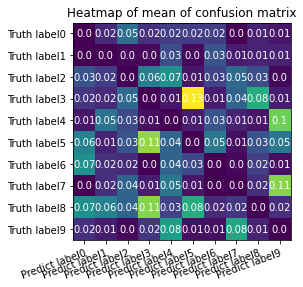

In [ ]:
truth_label = ["Truth label" + str(i) for i in range(10)]
pred_label = ["Predict label" + str(i) for i in range(10)]

h_map = np.mean(confusion_mat,axis=0) * 100

fig, ax = plt.subplots()
im = ax.imshow(h_map)

# Show all ticks and label them with the respective list entries
ax.set_yticks(np.arange(len(truth_label)), labels=truth_label)
ax.set_xticks(np.arange(len(pred_label)), labels=pred_label)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=20, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(truth_label)):
    for j in range(len(pred_label)):
        text = ax.text(j, i, round(h_map[i, j],2),
                       ha="center", va="center", color="w")

ax.set_title("Heatmap of mean of confusion matrix")
# fig.tight_layout()
plt.savefig('1-3', dpi=800)
plt.show()

## 1.4

In [ ]:
label = np.argsort(abs(record_box)[:,0])[-5:]

In [ ]:
print('The index of five hardest label' + '\n')
print(label)

array([5470, 5857, 5145, 8261, 5296])

In [ ]:
print('record box of these five labels' + '\n')
print('[0] represents the wrong times, [1] represents the wrong confidence value' + '\n')
print(record_box[label[:]])

array([[4.00000000e+00, 6.97856210e+06],
       [4.00000000e+00, 1.03977299e+07],
       [6.00000000e+00, 6.98836795e+06],
       [1.00000000e+01, 5.13874421e+15],
       [2.00000000e+01, 4.16051628e+16]])

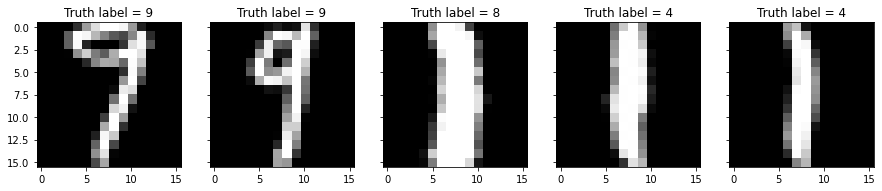

In [ ]:
print('Five hardest label' + '\n')
fig, axis = plt.subplots(1, 5, sharey = True, figsize = (15, 10))
for i in range(len(label)):
    reshape_img = np.reshape(X[label[i]], (16, 16))
    axis[i].imshow(reshape_img, cmap='gray')
    axis[i].title.set_text(("Truth label = " + str(y[label[i]])))
plt.savefig('Five hardest label', dpi=500)

## 1.5

### functions for 1.5

In [ ]:
# Define functions for PART1.5
from numpy.linalg import norm

def random_split(X, y, split_ratio=1/5):
    # This function aims to randomly split data to 80% for training, 20% for testing
    '''
        Input: 
            -X whole data matrix m*n, m represents data points, n represents data dimensions
            -y whole data label vector m*1
        
        Output:
            -X_train training data matrix
            -X_test testing data matrix
            -y_train training data label
            -y_test testing data label 
    '''
    data_idx = np.array([i for i in range(len(X))])
    np.random.shuffle(data_idx)
    test_size = int(len(X) * split_ratio)
    X_test = np.array([X[data_idx[i]] for i in range(test_size)])
    y_test = np.array([y[data_idx[i]] for i in range(test_size)])
    X_train = np.array([X[data_idx[i]] for i in range(test_size, len(X))])
    y_train = np.array([y[data_idx[i]] for i in range(test_size, len(y))])
    return X_train, y_train, X_test, y_test


def cross_validation(X, y, k):
    # This function aims to provide two list, each of them containing 
    # 5 sets of training data/label
    '''
        Input: 
            -X: whole data matrix m*n, m represents data points, n represents data dimensions
            -y: whole data label vector m*1

        Output:
            -X_train: list, containing 5 sets of training data
            -y_train: list, containing 5 sets of training label
    '''
    data_idx = [i for i in range(len(X))]
    np.random.shuffle(data_idx)
    len_train = len(X)//k
    X_train = [X[data_idx[i*len_train:(i+1)*len_train]] for i in range(k-1)]
    X_valid = X[data_idx[(k-1)*len_train:]]
    X_train.append(X_valid)

    y_train = [y[data_idx[i*len_train:(i+1)*len_train]] for i in range(k-1)]
    y_valid = y[data_idx[(k-1)*len_train:]]
    y_train.append(y_valid)

    return X_train, y_train


def kernel(p, q, c):
    return np.exp(-c* norm(p-q)**2)


def K_matrix(X1, X2, c):
    '''
        Get the kernel matrix for each point in X, size m*m
        Using bradcase to speed up

        Input: -x: array, input training data
            -sigma: float, kernel parameter
        Output: array (m*m), with each element representing kernel value
    '''
    out = np.zeros((len(X2),len(X1)))
    for i, x in enumerate(X2):
        out[i] = np.exp(-c*np.sum((x - X1)**2, axis=1))
    return out       


def sign(x):
    #This function realize the sign function
    if x < 0:
        return -1
    elif x > 0:
        return 1
    else:
        return 0


def train(X_train, y_train, alpha, num_class, kernel_mat, c):
    '''
        Input:
            -X_train, training data matrix with size m_train * n
            -y_train, training data label vector with size m_train * 1
            -alpha, weight vector with size m_train * num_class
            -num_class, int, number of class, in our case is 10
            -kernel_mat, kernel matrix of training set.
            -c, parameter inside kernel function
        
        Output:
            -mistakes, int, number of mistakes detected in training one epoch
            -end-start, float, time spent on training one epoch
            -alpha, updated weighting vector, m_train * num_class
    '''
    start = time.time()
    mistakes = 0
    for i in range(len(X_train)):
        max_val = -float('inf')
        max_idx = -1
        for j in range(num_class):
            y_for_now = 1 if y_train[i] == j else -1
            pred_val = np.dot(kernel_mat[i], alpha[j])
            if sign(pred_val) != y_for_now: #predict wrong value; alpha[t] = y[t]
                if sign(pred_val) == 0:
                    alpha[j][i] = y_for_now
                alpha[j][i] -= sign(pred_val) #update alpha

            else: #predict right value, record confidence
                if pred_val > max_val:
                    max_val = pred_val #assign new max value
                    max_idx = j #record idx with max confidence
        #wrong prediction
        if max_idx != y_train[i]:
            mistakes += 1
    end = time.time()
        
    return mistakes, end-start, alpha

def test(X_train, X_test, y_test, alpha, num_class, kernel_mat, c):
    '''
        Input:
            -X_train, training data matrix with size m_train * n
            -y_train, training data label vector with size m_train * 1
            -alpha, weight vector with size m_train * num_class
            -num_class, int, number of class, in our case is 10
            -kernel_mat, kernel matrix of testing set.
            -c, parameter inside kernel function
        Output:   
            -mistakes, int, number of mistakes detected in testing one epoch
            -end-start, float, time spent on testing one epoch
    '''
    import time
    start = time.time()
    mistakes = 0
    for i in range(len(X_test)):
        max_val = -float('inf')
        for j in range(num_class):
            y_for_now = 1 if y_test[i] == j else -1
            pred_val = np.dot(kernel_mat[i], alpha[j])
            if pred_val > max_val:
                max_val = pred_val
                max_idx = j
        #wrong prediction        
        if max_idx != y_test[i]:
            mistakes += 1
    end = time.time()
    return mistakes, end-start


def test_confusion(X_train, X_test, y_test, alpha, num_class, kernel_mat, d, confusion_matrix):
    #This function aims to provide a test containing confusion matrix
    '''
        Input:
            -X_train, training data matrix with size m_train * n
            -y_train, training data label vector with size m_train * 1
            -alpha, weight vector with size m_train * num_class
            -num_class, int, number of class, in our case is 10
            -d, parameter inside kernel function
            -confusion_matrix, matrix filled with all 0s with size 10*10
                each entry ij represents the error rate of label i 
                being wrongly predict to label j
        Output:
            -mistakes, int, number of mistakes detected in testing one epoch
            -end-start, float, time spent on testing one epoch
            -confusion_matrix/len(X_test) updated normalized confusion matrix
    '''
    import time
    start = time.time()
    mistakes = 0
    for i in range(len(X_test)):
        max_val = -float('inf')
        for j in range(num_class):
            y_for_now = 1 if y_test[i] == j else -1
            pred_val = np.dot(kernel_mat[i], alpha[j])
            # pred_val = pred(X_train, X_test[i], alpha[j], d)
            if pred_val > max_val:
                max_val = pred_val
                max_idx = j
        #wrong prediction        
        if max_idx != y_test[i]:
            mistakes += 1
            confusion_matrix[y_test[i]][max_idx] += 1
    end = time.time()
    return mistakes, end-start, confusion_matrix/len(X_test)




### 1.5.1

In [ ]:

d_list = [10**i for i in range(-5, 5)]
num_class = 10
runs = 10



train_error_rate_list = [[] for _ in range(len(d_list))]
test_error_rate_list = [[] for _ in range(len(d_list))]

for run in range(runs):
    print('Run: {0:}'.format(run))
    print('-------------------------------------------------------------------------------------------------\n')

    #split data set to 80% and 20%
    X_train, y_train, X_test, y_test = random_split(X, y)
   
    ##code test setting
    # X_train = X_train[:300]
    # y_train = y_train[:300]
    # X_test = X_test[:100]
    # y_test = y_test[:100]
    

    #initialize alpha
    alpha = np.array([[[0 for _ in range(len(X_train))] for _ in range(num_class)] for _ in range(len(d_list))])
    for d_idx, d in enumerate(d_list):
        print('Start training')
        print('---------------------------------------------------\n')
        train_total_error = 0
        test_total_error = 0
        store_box = [float('inf'), alpha[d_idx]]
        epochs = 0
        kernel_mat_train = K_matrix(X_train, X_train, d)
        kernel_mat_test = K_matrix(X_train, X_test, d)

        
        while epochs < 100:
            #train
            train_mistakes, times, alpha[d_idx]= train(X_train, y_train, alpha[d_idx], num_class, kernel_mat_train, d)
            print('Training - epoch{0:} required {1:.2f}s with {2:} mistakes out of {3:} items\n'.format(epochs, times, train_mistakes, len(X_train)))
            train_total_error += train_mistakes

            if train_mistakes < store_box[0]:
                store_box[0], store_box[1] = train_mistakes, alpha[d_idx]
                epochs += 1
            else:
                alpha[d_idx] = store_box[1]
                print('\nWe stop training the classifier with d = {0:} at epoch {1:}'.format(d, epochs))
                train_error_rate_list[d_idx].append(train_total_error / epochs / len(X_train))
                break
        #testing
        test_mistakes, times = test(X_train, X_test, y_test, alpha[d_idx], num_class, kernel_mat_test, d)
        print('\n########################################')
        print('Start testing')
        print('Testing on with d = {0:} -- It required {1:.2f}s with a test error of {2:.2f}%'.format(d, times, test_mistakes/len(X_test)*100))
        print('########################################\n')
        test_total_error += test_mistakes
        test_error_rate_list[d_idx].append(test_total_error / len(X_test))
        
        print('Finish training with d = {0:}'.format(d))
        print('---------------------------------------------------\n')
    

    print('Finish Run: {0:}'.format(run))
    print('-------------------------------------------------------------------------------------------------\n')


        


    

Run: 0
-------------------------------------------------------------------------------------------------

Start training
---------------------------------------------------

Training - epoch0 required 0.47s with 5099 mistakes out of 7439 items

Training - epoch1 required 0.49s with 4472 mistakes out of 7439 items

Training - epoch2 required 0.47s with 3960 mistakes out of 7439 items

Training - epoch3 required 0.46s with 3332 mistakes out of 7439 items

Training - epoch4 required 0.46s with 3007 mistakes out of 7439 items

Training - epoch5 required 0.46s with 2775 mistakes out of 7439 items

Training - epoch6 required 0.46s with 2532 mistakes out of 7439 items

Training - epoch7 required 0.46s with 2339 mistakes out of 7439 items

Training - epoch8 required 0.46s with 2175 mistakes out of 7439 items

Training - epoch9 required 0.46s with 2047 mistakes out of 7439 items

Training - epoch10 required 0.46s with 1933 mistakes out of 7439 items

Training - epoch11 required 0.46s with 1869 

In [ ]:
print('Mean training error of 10 different c (%)' + '\n')
print(np.mean(train_error_rate_list, axis=1) * 100)

array([34.16883519, 23.57064078, 10.28037177,  1.79449775,  2.05616154,
        2.42308554,  8.22451494, 32.9188511 , 49.97714747, 50.        ])

In [ ]:
print('Standard Deviation of training error of 10 different d (%)' + '\n')
print(np.std(train_error_rate_list, axis=1) * 100)

array([1.16664935, 2.65565339, 1.64272188, 0.36819236, 0.42030183,
       0.29595686, 1.21376511, 5.97323547, 0.0061602 , 0.        ])

In [ ]:
print('Mean testing error of 10 different c (%)' + '\n')
print(np.mean(test_error_rate_list, axis=1) * 100)

array([16.61108123, 12.08714363,  6.18074233,  2.59279182,  5.15330823,
        6.68639053, 19.7471759 , 71.39322216, 82.85637439, 82.96933835])

In [ ]:
print('Standard Deviation of testing error of 10 different d (%)' + '\n')
print(np.std(test_error_rate_list, axis=1) * 100)

array([4.19572144, 2.1336047 , 0.96089782, 0.38700604, 0.60563606,
       0.55853467, 0.74709438, 0.72561888, 0.64776814, 0.63793296])

### 1.5.2

In [ ]:
k_fold = 5
d_list = [i*0.001 for i in range(10,31)]
num_class = 10
runs = 20


optimal_d_list = []
train_total_list = []
valid_total_list = []

retrain_error_list = []


confusion_mat = np.zeros((runs, num_class, num_class)) #20*10*10的矩阵 20个10*10的confusion matrix

for run in range(runs):
    print('Run: {0:}'.format(run))
    print('-------------------------------------------------------------------------------------------------\n')
 
    #split data set to 80% and 20%
    X_train_w, y_train_w, X_test, y_test = random_split(X, y)

    # code test setting
    # X_train_w = X_train_w[:2000]
    # y_train_w = y_train_w[:2000]
    # X_test = X_test[:100]
    # y_test = y_test[:100]
    
    #split X_train, y_train to 5 subset and form a list for each of them
    X_train_list, y_train_list = cross_validation(X_train_w, y_train_w, k_fold)

    train_error_rate_list = [[0 for _ in range(k_fold)] for _ in range(len(d_list))]
    valid_error_rate_list = [[0 for _ in range(k_fold)] for _ in range(len(d_list))]

    print('Start K-fold cross validation')
    print('------------------------------------------------------------------------------\n')
    for k in range(k_fold):
        # obtain X_train, X_valid, y_train, y_valid in cross validation
        X_train_cv = []
        X_valid_cv = []
        y_train_cv = []
        y_valid_cv = []
        idx_list = [i for i in range(k_fold)]
        X_valid_cv.extend(X_train_list[k])
        y_valid_cv.extend(y_train_list[k])
        idx_list.remove(k)
        for idx in idx_list:
            X_train_cv.extend(X_train_list[idx])
            y_train_cv.extend(y_train_list[idx])
        
        X_train, X_valid, y_train, y_valid = X_train_cv, X_valid_cv, y_train_cv, y_valid_cv

        #calculate kernel_matrix in advance
        kernel_mat_train = [K_matrix(X_train, X_train, d) for d in d_list]
        kernel_mat_valid = [K_matrix(X_valid, X_train, d) for d in d_list]


        #initialize alpha for all
        alpha = np.array([[[0 for _ in range(len(X_train))] for _ in range(num_class)] for _ in range(len(d_list))])
        for d_idx, d in enumerate(d_list):
            print('{0:}th fold: d = {1:}'.format(k, d))
            print('Start training')
            print('---------------------------------------------------\n')
            train_total_error = 0
            valid_total_error = 0
            store_box = [float('inf'), alpha[d_idx]]
            epochs = 0

            #training
            while epochs < 100:
                
                train_mistakes, times, alpha[d_idx]= train(X_train, y_train, alpha[d_idx], num_class, kernel_mat_train[d_idx], d)
                print('Training - epoch{0:} required {1:.2f}s with {2:} mistakes out of {3:} items\n'.format(epochs, times, train_mistakes, len(X_train)))
                train_total_error += train_mistakes

                if train_mistakes < store_box[0]:
                    store_box[0], store_box[1] = train_mistakes, alpha[d_idx]
                    epochs += 1
                else:
                    alpha[d_idx] = store_box[1]
                    print('\nWe stop training the classifier with d = {0:} at epoch {1:}'.format(d, epochs))

                    train_error_rate_list[d_idx][k] += train_total_error / epochs / len(X_train)
                    
                    break
            #validating
            valid_mistakes, times = test(X_train, X_valid, y_valid, alpha[d_idx], num_class, kernel_mat_valid[d_idx], d)
            print('\n########################################')
            print('Start validating')
            print('Validating on with d = {0:} on fold No.{1:} -- It required {2:.2f}s with a valid error of {3:.2f}%'.format(d, k, times, valid_mistakes/len(X_valid)*100))
            print('########################################\n')
            valid_total_error += valid_mistakes
            valid_error_rate_list[d_idx][k] += valid_total_error / len(X_valid)
            
            print('Finish training with d = {0:}'.format(d))
            print('---------------------------------------------------\n')
    
    print('Finish K-fold cross validation')
    print('------------------------------------------------------------------------------\n')

    print('Finish Run: {0:}'.format(run))
    print('-------------------------------------------------------------------------------------------------\n')


    #select d that makes valid_error the smallest
    optimal_d = d_list[np.argmin(np.mean(valid_error_rate_list, axis = 1))]
    optimal_d_list.append(optimal_d)

    train_total_list.append(train_error_rate_list)
    valid_total_list.append(valid_error_rate_list)



    #retrain on full 80% dataset using optimal_d in this run
    #initialization setting
    alpha = np.array([[0 for _ in range(len(X_train_w))] for _ in range(num_class)])
    epochs = 0
    store_box = [float('inf'), alpha]
    kernel_mat_train = K_matrix(X_train_w, X_train_w, optimal_d)
    kernel_mat_test = K_matrix(X_train_w, X_test, optimal_d)
    
    
    while epochs < 100:
        train_mistakes, times, alpha = train(X_train_w, y_train_w, alpha, num_class, kernel_mat_train, optimal_d)
        print('Training on full data set - epoch{0:} required {1:.2f}s with {2:} mistakes out of {3:} items\n'.format(epochs, times, train_mistakes, len(X_train_w)))

        if train_mistakes < store_box[0]:
            store_box[0], store_box[1] = train_mistakes, alpha
            epochs += 1
        else:
            alpha = store_box[1]
            print('\nWe stop training the classifier with optimal d = {0:} at epoch {1:}'.format(optimal_d, epochs))
            break

    #testing
    test_mistakes, times, confusion_mat[run] = test_confusion(X_train_w, X_test, y_test, alpha, num_class, kernel_mat_test, optimal_d, confusion_mat[run])
    retrain_error_list.append(test_mistakes/len(X_test))
    print('\n########################################')
    print('Start testing')
    print('testing on with optimal d = {0:} -- It required {1:.2f}s with a test error of {2:.2f}%'.format(optimal_d, times, test_mistakes/len(X_test)*100))
    print('########################################\n')

        

        


    

Run: 0
-------------------------------------------------------------------------------------------------

Start K-fold cross validation
------------------------------------------------------------------------------

0th fold: d = 0.01
Start training
---------------------------------------------------

Training - epoch0 required 0.55s with 617 mistakes out of 5952 items

Training - epoch1 required 0.30s with 158 mistakes out of 5952 items

Training - epoch2 required 0.31s with 77 mistakes out of 5952 items

Training - epoch3 required 0.31s with 47 mistakes out of 5952 items

Training - epoch4 required 0.31s with 27 mistakes out of 5952 items

Training - epoch5 required 0.31s with 20 mistakes out of 5952 items

Training - epoch6 required 0.30s with 16 mistakes out of 5952 items

Training - epoch7 required 0.30s with 10 mistakes out of 5952 items

Training - epoch8 required 0.30s with 5 mistakes out of 5952 items

Training - epoch9 required 0.30s with 5 mistakes out of 5952 items


We sto

In [ ]:
print('Mean of 20 testing error (%) with optimal c selected by k-fold cross validation' + '\n')
print(np.mean(retrain_error_list))

0.026304464766003226

In [ ]:
print('20 testing error (%) with optimal c selected by k-fold cross validation' + '\n')
print(np.array(retrain_error_list)*100)

array([2.25927918, 2.63582571, 2.25927918, 2.36686391, 3.22754169,
       2.31307154, 2.15169446, 2.0979021 , 2.74341044, 3.33512641,
       2.0979021 , 2.7972028 , 3.01237224, 2.20548682, 2.85099516,
       2.47444863, 2.7972028 , 3.22754169, 3.22754169, 2.52824099])

In [ ]:
print('Standard deviation of 20 testing error (%) with optimal c selected by k-fold cross validation' + '\n')
np.std(retrain_error_list)

0.004053746106642432

In [ ]:
print('optimal c list selected by k fold cross validation')
print(optimal_d_list)

array([0.011, 0.016, 0.012, 0.01 , 0.019, 0.022, 0.016, 0.019, 0.017,
       0.013, 0.015, 0.013, 0.018, 0.02 , 0.015, 0.023, 0.017, 0.022,
       0.013, 0.018])

In [ ]:
print('mean optimal c over 20 runs')
print(np.mean(optimal_d_list))

0.01645

In [ ]:
print('Standard deviation of optimal c over 20 runs')
print(np.std(optimal_d_list))

0.0036534230524263127

### comparison to Polynomial Kernel

In [ ]:
print('Start comparing between Polynomial kernel and Gaussian kernel')
d_list = [0.01645]
num_class = 10
runs = 10
total_epochs = 0
total_time = 0

for run in range(runs):
    print('Run: {0:}'.format(run))
    print('-------------------------------------------------------------------------------------------------\n')

    #split data set to 80% and 20%
    X_train, y_train, X_test, y_test = random_split(X, y)
   
    ##code test setting
    # X_train = X_train[:300]
    # y_train = y_train[:300]
    # X_test = X_test[:100]
    # y_test = y_test[:100]
    

    #initialize alpha
    alpha = np.array([[[0 for _ in range(len(X_train))] for _ in range(num_class)] for _ in range(len(d_list))])
    for d_idx, d in enumerate(d_list):
        print('Start training')
        print('---------------------------------------------------\n')
        store_box = [float('inf'), alpha[d_idx]]
        epochs = 0
        time_k = 0
        # kernel_mat_train = K_matrix(X_train, X_train, d)
        # kernel_mat_test = K_matrix(X_train, X_test, d)
        kernel_mat_train = kernel1(X_train, X_train, d)
        kernel_mat_test = kernel1(X_test, X_train, d)
        while epochs < 100:
            #train
            train_mistakes, times, alpha[d_idx]= train(X_train, y_train, alpha[d_idx], num_class, kernel_mat_train, d)
            print('Training - epoch{0:} required {1:.2f}s with {2:} mistakes out of {3:} items\n'.format(epochs, times, train_mistakes, len(X_train)))
            time_k += times

            if train_mistakes < store_box[0]:
                store_box[0], store_box[1] = train_mistakes, alpha[d_idx]
                epochs += 1
            else:
                alpha[d_idx] = store_box[1]
                print('\nWe stop training the classifier with d = {0:} at epoch {1:}'.format(d, epochs))
                total_epochs += epochs
                total_time += time_k / epochs
                break
    

    print('Finish Run: {0:}'.format(run))
    print('-------------------------------------------------------------------------------------------------\n')


        


    

Run: 0
-------------------------------------------------------------------------------------------------

Start training
---------------------------------------------------

Training - epoch0 required 0.46s with 606 mistakes out of 7439 items

Training - epoch1 required 0.47s with 135 mistakes out of 7439 items

Training - epoch2 required 0.46s with 53 mistakes out of 7439 items

Training - epoch3 required 0.46s with 29 mistakes out of 7439 items

Training - epoch4 required 0.46s with 18 mistakes out of 7439 items

Training - epoch5 required 0.47s with 12 mistakes out of 7439 items

Training - epoch6 required 0.46s with 4 mistakes out of 7439 items

Training - epoch7 required 0.46s with 6 mistakes out of 7439 items


We stop training the classifier with d = 0.01645 at epoch 7
Finish Run: 0
-------------------------------------------------------------------------------------------------

Run: 1
---------------------------------------------------------------------------------------------

In [ ]:
print('Averaged epoches trained to be converged with Gaussian Kernel using optimal c' + '\n')
print(total_epochs/10)

7.4

In [ ]:
print('Averaged time spent for one epoch with Gaussian Kernel using optimal c:' + '\n')
print(total_time/10)

0.5239398684293504

In [ ]:
def kernel(x1, x2, d):
    return (np.dot(x1, x2))**d
    
d_list = [5]
num_class = 10
runs = 10
total_epochs = 0
total_time = 0

for run in range(runs):
    print('Run: {0:}'.format(run))
    print('-------------------------------------------------------------------------------------------------\n')

    #split data set to 80% and 20%
    X_train, y_train, X_test, y_test = random_split(X, y)
   
    ##code test setting
    # X_train = X_train[:300]
    # y_train = y_train[:300]
    # X_test = X_test[:100]
    # y_test = y_test[:100]
    

    #initialize alpha
    alpha = np.array([[[0 for _ in range(len(X_train))] for _ in range(num_class)] for _ in range(len(d_list))])
    for d_idx, d in enumerate(d_list):
        print('Start training')
        print('---------------------------------------------------\n')
        store_box = [float('inf'), alpha[d_idx]]
        epochs = 0
        time_k = 0
        # kernel_mat_train = K_matrix(X_train, X_train, d)
        # kernel_mat_test = K_matrix(X_train, X_test, d)
        kernel_mat_train = kernel(X_train, np.transpose(X_train), d)
        kernel_mat_test = kernel(X_test, np.transpose(X_train), d)
        while epochs < 100:
            #train
            train_mistakes, times, alpha[d_idx]= train(X_train, y_train, alpha[d_idx], num_class, kernel_mat_train, d)
            print('Training - epoch{0:} required {1:.2f}s with {2:} mistakes out of {3:} items\n'.format(epochs, times, train_mistakes, len(X_train)))
            time_k += times

            if train_mistakes < store_box[0]:
                store_box[0], store_box[1] = train_mistakes, alpha[d_idx]
                epochs += 1
            else:
                alpha[d_idx] = store_box[1]
                print('\nWe stop training the classifier with d = {0:} at epoch {1:}'.format(d, epochs))
                total_epochs += epochs
                total_time += time_k / epochs
                break
    

    print('Finish Run: {0:}'.format(run))
    print('-------------------------------------------------------------------------------------------------\n')


        


    

Run: 0
-------------------------------------------------------------------------------------------------

Start training
---------------------------------------------------

Training - epoch0 required 0.46s with 620 mistakes out of 7439 items

Training - epoch1 required 0.46s with 157 mistakes out of 7439 items

Training - epoch2 required 0.46s with 69 mistakes out of 7439 items

Training - epoch3 required 0.46s with 50 mistakes out of 7439 items

Training - epoch4 required 0.46s with 31 mistakes out of 7439 items

Training - epoch5 required 0.46s with 25 mistakes out of 7439 items

Training - epoch6 required 0.46s with 9 mistakes out of 7439 items

Training - epoch7 required 0.46s with 8 mistakes out of 7439 items

Training - epoch8 required 0.46s with 4 mistakes out of 7439 items

Training - epoch9 required 0.46s with 4 mistakes out of 7439 items


We stop training the classifier with d = 5 at epoch 9
Finish Run: 0
---------------------------------------------------------------------

In [ ]:
print('Averaged epoches trained to be converged with Polynomial Kernel using optimal d:' + '\n')
print(total_epochs/10)

8.4

In [ ]:
print('Averaged time spent for one epoch with Polynomial Kernel using optimal d:' + '\n')
print(total_time/10)

0.5165851545523084

## 1.6

### functions for 1.6

In [ ]:
# Define functions for PART1
def random_split(X, y, split_ratio=1/5):
    # This function aims to randomly split data to 80% for training, 20% for testing
    '''
        Input: 
            -X whole data matrix m*n, m represents data points, n represents data dimensions
            -y whole data label vector m*1
        
        Output:
            -X_train training data matrix
            -X_test testing data matrix
            -y_train training data label
            -y_test testing data label 
    '''
    data_idx = np.array([i for i in range(len(X))])
    np.random.shuffle(data_idx)
    test_size = int(len(X) * split_ratio)
    X_test = np.array([X[data_idx[i]] for i in range(test_size)])
    y_test = np.array([y[data_idx[i]] for i in range(test_size)])
    X_train = np.array([X[data_idx[i]] for i in range(test_size, len(X))])
    y_train = np.array([y[data_idx[i]] for i in range(test_size, len(y))])
    return X_train, y_train, X_test, y_test


def cross_validation(X, y, k):
    # This function aims to provide two list, each of them containing 
    # 5 sets of training data/label
    '''
        Input: 
            -X: whole data matrix m*n, m represents data points, n represents data dimensions
            -y: whole data label vector m*1

        Output:
            -X_train: list, containing 5 sets of training data
            -y_train: list, containing 5 sets of training label
    '''
    data_idx = [i for i in range(len(X))]
    np.random.shuffle(data_idx)
    len_train = len(X)//k
    X_train = [X[data_idx[i*len_train:(i+1)*len_train]] for i in range(k-1)]
    X_valid = X[data_idx[(k-1)*len_train:]]
    X_train.append(X_valid)

    y_train = [y[data_idx[i*len_train:(i+1)*len_train]] for i in range(k-1)]
    y_valid = y[data_idx[(k-1)*len_train:]]
    y_train.append(y_valid)

    return X_train, y_train


def cal_mat(num_class):
    # This function aims to create a manipulation matrix used to convert 
    # the 45 outputs from 45 classifers to voting results for 10 labels
    '''
        Input: 
            -num_class: int, number of class
        Output:
            -cal_mat: manipulation matrix, used to convert the 45 outputs to voting results for 10 labels
    '''
    cal_mat = np.zeros((num_class, int(num_class*(num_class-1)/2)))
    #add 1
    start_idx = 0
    for p in range(len(cal_mat)):
        cal_mat[p][start_idx: start_idx + num_class-p-1] = 1
        start_idx = start_idx+num_class-p-1
    #add -1
    #row 1
    for i in range(1, num_class):
        cal_mat[i][i-1] = -1
    #row 2
    for i in range(2, num_class):
        cal_mat[i][i+7] = -1
    #row 3
    for i in range(3, num_class):
        cal_mat[i][i+14] = -1
    #row 4
    for i in range(4, num_class):
        cal_mat[i][i+20] = -1
    #row 5
    for i in range(5, num_class):
        cal_mat[i][i+25] = -1
    #row 6
    for i in range(6, num_class):
        cal_mat[i][i+29] = -1
    #row 7
    for i in range(7, num_class):
        cal_mat[i][i+32] = -1
    #row 8
    for i in range(8, num_class):
        cal_mat[i][i+34] = -1
    #row 9
    cal_mat[-1][-1] = -1
    return cal_mat


def kernel(x1, x2, d):
    # Polynomial kernel
    return (np.dot(x1, x2))**d

def sign(x):
    # Sign function
    if x < 0:
        return -1
    elif x > 0:
        return 1
    else:
        return 0

def get_idx(label):
    # This function aims to provide the index list of classifier corresponding to the input label
    '''
        Input: 
            -label: int, label range from 0 - 9
        Output:
            -idx_list 1: the index list of classifier corresponding to the main target label
            -idx_list 2: the index list of classifier corresponding to the side target label
            By main and side, i.e. classifer 01 tends to classify label 0 out of label 1
            The main target label is label 0,
            while the side target label is label 1.
    '''
    idx_list1 = [int(((9-i+1)+9)*i/2+label-1-i) for i in range(label)]
    idx_list2 = [int(((9-label+1)+9)*label/2 + i) for i in range(num_class-label-1)]
    return idx_list2, idx_list1


def train(X_train, y_train, alpha, num_class, kernel_mat, d):
    # This function realize the training process of one epoch of perceptron with polynomial kernel (OvO)
    '''
        Input:
            -X_train, training data matrix with size m_train * n
            -y_train, training data label vector with size m_train * 1
            -alpha, weight vector with size m_train * num_class
            -num_class, int, number of class, in our case is 10
            -kernel_mat, training kernel matrix
            -d, polynomial degree in kernel
        
        Output:
            -mistakes, int, number of mistakes detected in training one epoch
            -end-start, float, time spent on training one epoch
            -alpha, updated weighting vector, m_train * num_class
    '''
    start = time.time()
    mistakes = 0
    calculate_mat = cal_mat(10)
    for i in range(len(X_train)):
        #alpha in 45*len(X_train)
        res = np.dot(alpha, kernel_mat[i]) #45*1
        if res.tolist() == [0.0 for _ in range(int(num_class * (num_class-1) * 1/2))]:
            mistakes += 1
        res = np.array([1 if i > 0 else -1 for i in res]) #45*1
        res = np.dot(calculate_mat, res) #10*1 
        vote_res = np.argmax(res)
        if vote_res != y_train[i]:
            mistakes += 1

        #For the specific y_train[i], we figure out which classifier should be updated.
        #Obtain corresponding index list
        forward_idx, backward_idx = get_idx(y_train[i])
        #In list of main target classifer, we transfer y_train[i] to 1
        if forward_idx != []:
            for idx in forward_idx:
                y_for_now = 1
                pred_val = np.dot(kernel_mat[i], alpha[idx])
                if sign(pred_val) != y_for_now: 
                    if sign(pred_val) == 0:
                        alpha[idx][i] = y_for_now
                    alpha[idx][i] -= sign(pred_val)
        # In list of side target classifier, we transfer y_train[i] to -1
        if backward_idx != []:
            for idx in backward_idx:
                y_for_now = -1
                pred_val = np.dot(kernel_mat[i], alpha[idx])
                if sign(pred_val) != y_for_now:
                    if sign(pred_val) == 0:
                        alpha[idx][i] = y_for_now
                    alpha[idx][i] -= sign(pred_val)

    end = time.time()
    return mistakes, end-start, alpha



def test(X_train, X_test, y_test, alpha, num_class, kernel_mat, d):
    # This function aims to realize the testing process of perceptron (OvO)
    '''
        Input:
            -X_train, training data matrix with size m_train * n
            -y_train, training data label vector with size m_train * 1
            -alpha, weight vector with size m_train * num_class
            -num_class, int, number of class, in our case is 10
            -kernel_mat, kernel matrix of testing set.
            -c, parameter inside kernel function
        Output:   
            -mistakes, int, number of mistakes detected in testing one epoch
            -end-start, float, time spent on testing one epoch
    '''
    start = time.time()
    mistakes = 0
    calculate_mat = cal_mat(10)
    for i in range(len(X_test)):
        res = np.dot(alpha, kernel_mat[i]) #45*1
        res = np.array([1 if i > 0 else -1 for i in res]) #45*1
        res = np.dot(calculate_mat, res) #10*1 
        vote_res = np.argmax(res)
        if vote_res != y_test[i]:
            mistakes += 1
    end = time.time()
    return mistakes, end-start






### 1.6.1

In [ ]:

d_list = [i for i in range(1,7+1)]
num_class = 10
runs = 20



train_error_rate_list = [[] for _ in range(len(d_list))]
test_error_rate_list = [[] for _ in range(len(d_list))]

for run in range(runs):
    print('Run: {0:}'.format(run))
    print('-------------------------------------------------------------------------------------------------\n')

    #split data set to 80% and 20%
    X_train, y_train, X_test, y_test = random_split(X, y)
   
    ##code test setting
    # X_train = X_train[:300]
    # y_train = y_train[:300]
    # X_test = X_test[:100]
    # y_test = y_test[:100]
    
    #initialize alpha
    alpha = np.zeros((len(d_list), int(num_class*(num_class-1)/2), len(X_train)))
    for d_idx, d in enumerate(d_list):
        print('Start training')
        print('---------------------------------------------------\n')
        train_total_error = 0
        test_total_error = 0
        store_box = [float('inf'), alpha[d_idx]]
        epochs = 0
        kernel_mat_train = kernel(X_train, np.transpose(X_train), d)
        kernel_mat_test = kernel(X_test, np.transpose(X_train), d)
        

        while epochs < 100:
            #train
            train_mistakes, times, alpha[d-1]= train(X_train, y_train, alpha[d-1], num_class, kernel_mat_train, d)
            print('Training - epoch{0:} required {1:.2f}s with {2:} mistakes out of {3:} items\n'.format(epochs, times, train_mistakes, len(X_train)))

            if train_mistakes < store_box[0]:
                store_box[0], store_box[1] = train_mistakes, alpha[d-1]
                epochs += 1
            else:
                alpha[d-1] = store_box[1]
                print('\nWe stop training the classifier with d = {0:} at epoch {1:}'.format(d, epochs))
                break
        
        #getting training error
        train_mistakes, times, alpha[d-1]= train(X_train, y_train, alpha[d-1], num_class, kernel_mat_train, d)
        print('\n########################################')
        print('Start obtaining training error')
        print('Training on with d = {0:} -- It required {1:.2f}s with a train error of {2:.2f}%'.format(d, times, train_mistakes/len(X_train)*100))
        print('########################################\n')
        train_error_rate_list[d-1].append(train_mistakes/len(X_train))
        
        #testing
        test_mistakes, times = test(X_train, X_test, y_test, alpha[d-1], num_class, kernel_mat_test, d)
        print('\n########################################')
        print('Start testing')
        print('Testing on with d = {0:} -- It required {1:.2f}s with a test error of {2:.2f}%'.format(d, times, test_mistakes/len(X_test)*100))
        print('########################################\n')
        test_error_rate_list[d-1].append(test_mistakes / len(X_test))
        
        print('Finish training with d = {0:}'.format(d))
        print('---------------------------------------------------\n')
    

    print('Finish Run: {0:}'.format(run))
    print('-------------------------------------------------------------------------------------------------\n')


    

Run: 0
-------------------------------------------------------------------------------------------------

Start training
---------------------------------------------------

Training - epoch0 required 2.53s with 988 mistakes out of 7439 items

Training - epoch1 required 2.67s with 544 mistakes out of 7439 items

Training - epoch2 required 2.13s with 469 mistakes out of 7439 items

Training - epoch3 required 2.02s with 426 mistakes out of 7439 items

Training - epoch4 required 2.08s with 317 mistakes out of 7439 items

Training - epoch5 required 2.18s with 307 mistakes out of 7439 items

Training - epoch6 required 1.91s with 269 mistakes out of 7439 items

Training - epoch7 required 2.01s with 265 mistakes out of 7439 items

Training - epoch8 required 2.01s with 228 mistakes out of 7439 items

Training - epoch9 required 2.03s with 202 mistakes out of 7439 items

Training - epoch10 required 2.10s with 191 mistakes out of 7439 items

Training - epoch11 required 2.14s with 189 mistakes out

In [ ]:
print('Mean training error of 7 different d (%) (OvO)' + '\n')
print(np.mean(train_error_rate_list, axis=1) * 100)

array([2.66702514, 0.1169512 , 0.06116413, 0.05108213, 0.03763947,
       0.0342788 , 0.03293453])

In [ ]:
print('Standard deviation of training error of 7 different d (%) (OvO)' + '\n')
np.std(train_error_rate_list, axis=1) * 100

array([0.73667042, 0.07839507, 0.03860527, 0.02774535, 0.02312764,
       0.02459494, 0.02422479])

In [ ]:
print('Mean testing error of 7 different d (%) (OvO)' + '\n')
print(np.mean(test_error_rate_list, axis=1) * 100)

array([6.27756859, 3.38622916, 3.13609467, 3.0661646 , 3.16568047,
       3.33781603, 3.5126412 ])

In [ ]:
print('Standard deviation of testing error of 7 different d (%) (OvO)' + '\n')
print(np.std(test_error_rate_list, axis=1) * 100)

array([0.78213798, 0.40127623, 0.32857403, 0.32587695, 0.34287093,
       0.39473295, 0.44459314])

### 1.6.2

In [ ]:
k_fold = 5
d_list = [i for i in range(1,7+1)]
num_class = 10
runs = 20
# k_fold = 3
# d_list = [i for i in range(1,7+1)]
# num_class = 10
# runs = 3

optimal_d_list = []
train_total_list = []
valid_total_list = []

retrain_error_list = []


for run in range(runs):
    print('Run: {0:}'.format(run))
    print('-------------------------------------------------------------------------------------------------\n')

    #split data set to 80% and 20%
    X_train_w, y_train_w, X_test, y_test = random_split(X, y)

    #code test setting
    # X_train_w = X_train_w[:300]
    # y_train_w = y_train_w[:300]
    # X_test = X_test[:100]
    # y_test = y_test[:100]
    
    #split X_train, y_train to 5 subset and form a list for each of them
    X_train_list, y_train_list = cross_validation(X_train_w, y_train_w, k_fold)

    train_error_rate_list = [[0 for _ in range(k_fold)] for _ in range(len(d_list))]
    valid_error_rate_list = [[0 for _ in range(k_fold)] for _ in range(len(d_list))]

    print('Start K-fold cross validation')
    print('------------------------------------------------------------------------------\n')
    for k in range(k_fold):
        # obtain X_train, X_valid, y_train, y_valid in cross validation
        X_train_cv = []
        X_valid_cv = []
        y_train_cv = []
        y_valid_cv = []
        idx_list = [i for i in range(k_fold)]
        X_valid_cv.extend(X_train_list[k])
        y_valid_cv.extend(y_train_list[k])
        idx_list.remove(k)
        for idx in idx_list:
            X_train_cv.extend(X_train_list[idx])
            y_train_cv.extend(y_train_list[idx])
        
        X_train, X_valid, y_train, y_valid = X_train_cv, X_valid_cv, y_train_cv, y_valid_cv

        alpha = np.zeros((len(d_list), int(num_class*(num_class-1)/2), len(X_train)))
        for d in d_list:
            print('{0:}th fold: d = {1:}'.format(k, d))
            print('Start training')
            print('---------------------------------------------------\n')
            train_total_error = 0
            valid_total_error = 0
            store_box = [float('inf'), alpha[d-1]]
            epochs = 0
             #initialize alpha
            kernel_mat_train = kernel(X_train, np.transpose(X_train), d)
            kernel_mat_valid = kernel(X_valid, np.transpose(X_train), d)
            while epochs < 100:
                #train
                train_mistakes, times, alpha[d-1]= train(X_train, y_train, alpha[d-1], num_class, kernel_mat_train, d)
                print('Training - epoch{0:} required {1:.2f}s with {2:} mistakes out of {3:} items\n'.format(epochs, times, train_mistakes, len(X_train)))
                train_total_error += train_mistakes

                if train_mistakes < store_box[0]:
                    store_box[0], store_box[1] = train_mistakes, alpha[d-1]
                    epochs += 1
                else:
                    alpha[d-1] = store_box[1]
                    print('\nWe stop training the classifier with d = {0:} at epoch {1:}'.format(d, epochs))

                    train_error_rate_list[d-1][k] += train_total_error / epochs / len(X_train)
                    
                    break
            #validating
            valid_mistakes, times = test(X_train, X_valid, y_valid, alpha[d-1], num_class, kernel_mat_valid, d)
            print('\n########################################')
            print('Start validating')
            print('Validating on with d = {0:} on fold No.{1:} -- It required {2:.2f}s with a valid error of {3:.2f}%'.format(d, k, times, valid_mistakes/len(X_valid)*100))
            print('########################################\n')
            valid_total_error += valid_mistakes
            valid_error_rate_list[d-1][k] += valid_total_error / len(X_valid)
            
            print('Finish training with d = {0:}'.format(d))
            print('---------------------------------------------------\n')
    
    print('Finish K-fold cross validation')
    print('------------------------------------------------------------------------------\n')

    print('Finish Run: {0:}'.format(run))
    print('-------------------------------------------------------------------------------------------------\n')


    #select d that makes valid_error the smallest
    optimal_d = np.argmin(np.mean(valid_error_rate_list, axis = 1))+1
    optimal_d_list.append(optimal_d)

    train_total_list.append(train_error_rate_list)
    valid_total_list.append(valid_error_rate_list)



    #retrain on full 80% dataset using optimal_d in this run
    #initialization
    alpha = np.zeros((int(num_class*(num_class-1)/2), len(X_train_w)))
    epochs = 0
    store_box = [float('inf'), alpha]
    kernel_mat_train = kernel(X_train_w, np.transpose(X_train_w), optimal_d)
    while epochs < 100:
        train_mistakes, times, alpha = train(X_train_w, y_train_w, alpha, num_class, kernel_mat_train, optimal_d)
        print('Training on full data set - epoch{0:} required {1:.2f}s with {2:} mistakes out of {3:} items\n'.format(epochs, times, train_mistakes, len(X_train_w)))

        if train_mistakes < store_box[0]:
            store_box[0], store_box[1] = train_mistakes, alpha
            epochs += 1
        else:
            alpha = store_box[1]
            print('\nWe stop training the classifier with optimal d = {0:} at epoch {1:}'.format(optimal_d, epochs))
            break

    #testing
    kernel_mat_test = kernel(X_test, np.transpose(X_train_w), optimal_d)
    test_mistakes, times = test(X_train_w, X_test, y_test, alpha, num_class, kernel_mat_test, optimal_d)
    retrain_error_list.append(test_mistakes/len(X_test))
    print('\n########################################')
    print('Start testing')
    print('testing on with optimal d = {0:} -- It required {1:.2f}s with a test error of {2:.2f}%'.format(optimal_d, times, test_mistakes/len(X_test)*100))
    print('########################################\n')

        

        


    

Run: 0
-------------------------------------------------------------------------------------------------

Start K-fold cross validation
------------------------------------------------------------------------------

0th fold: d = 1
Start training
---------------------------------------------------

Training - epoch0 required 1.72s with 841 mistakes out of 5952 items

Training - epoch1 required 2.50s with 447 mistakes out of 5952 items

Training - epoch2 required 2.13s with 371 mistakes out of 5952 items

Training - epoch3 required 1.70s with 320 mistakes out of 5952 items

Training - epoch4 required 1.77s with 266 mistakes out of 5952 items

Training - epoch5 required 2.11s with 240 mistakes out of 5952 items

Training - epoch6 required 1.45s with 196 mistakes out of 5952 items

Training - epoch7 required 1.45s with 191 mistakes out of 5952 items

Training - epoch8 required 1.38s with 154 mistakes out of 5952 items

Training - epoch9 required 1.32s with 151 mistakes out of 5952 items



In [ ]:
print('20 testing error with optimal d selected by k-fold cross validation (OvO)' + '\n')
print(np.array(retrain_error_list))

array([0.03119957, 0.02420656, 0.04034427, 0.03711673, 0.03550296,
       0.02850995, 0.03227542, 0.02528241, 0.03173749, 0.03550296,
       0.02904788, 0.03442711, 0.02797203, 0.03550296, 0.03173749,
       0.03442711, 0.03012372, 0.03173749, 0.02797203, 0.0295858 ])

In [ ]:
print('Mean of 20 testing error (%) with optimal d selected by k-fold cross validation (OvO)' + '\n')
print(np.mean(retrain_error_list) * 100)

3.1710597095212476

In [ ]:
print('Standard deviation of 20 testing error (%) with optimal d selected by k-fold cross validation (OvO)' + '\n')
print(np.std(retrain_error_list) * 100)

0.39509931076650234

In [ ]:
print('optimal d list selected by 20 runs (OvO)')
print(optimal_d_list)

[5, 5, 3, 3, 4, 3, 4, 5, 4, 3, 5, 5, 3, 3, 4, 4, 3, 5, 3, 4]

In [ ]:
print('Mean value of optimal d list selected by 20 runs (OvO)')
print(np.mean(optimal_d_list))

3.9

In [ ]:
print('Standard deviation of optimal d list selected by 20 runs (OvO)')
print(np.std(optimal_d_list))

0.8306623862918076

# PART2

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm, eig

In [ ]:
def W_matrix(xdata, c):
    '''
    With W_ij = exp(-c||x_i-x_j||^2), we get the W matrix.

    input:
        -xdata: array (m*n), the input data
        -c: float, parameter c
    output:
        -W: array (m*m), the weight matrix
    '''
    num_samples, dim_samples = xdata.shape[0], xdata.shape[1]
    W = np.zeros((num_samples, num_samples))
    for row in range(W.shape[0]):
        for col in range(W.shape[1]):
            W[row][col] = np.exp(-c*norm(xdata[row]-xdata[col])**2)
    return W

def L_matrix(W):
    '''
    Define D as the diagonal matrix which D_ii=sum of i-th row of W.
    Then we get graph laplacian L = D - W

    input:
        -W: array(m*m), the weight matrix
    output:
        -L: array(m*m), the graph laplacian
    '''
    diagonal_sum = np.sum(W, axis=1)
    L = -W
    for i in range(len(W)):
        L[i][i] = diagonal_sum[i] - W[i][i]
    return L

def cluster(L):
    '''
    Compute eigenvalues and eigenvectors of L, then sort eigenvalues. Pick 
    the eigenvector with the second smallest eigenvalue. Predict y_i by 
    determining the sign of i-th element of the eigenvector.

    input:
        -L: array(m*m), the graph laplacian
    output:
        -y_hat: array(1*m), our predicted y
    '''
    eigenvalue, eigenvector = eig(L)
    eig_dict = {eigenvalue[i]:eigenvector[:,i] for i in range(len(eigenvalue))}
    v2 = eig_dict[sorted(eig_dict)[1]]
    y_hat = np.zeros(len(L))
    for i in range(len(L)):
        if v2[i] >= 0:
            y_hat[i] = 1
        else:
            y_hat[i] = -1
    return y_hat

def plot_best_figure(x, y, c_list, task=1):
    '''
    With given inputs, labels, and parameter c list, choose c which could (almost)
    correctly cluster data. Then plot the clustering figure. Finally return the 
    optimal c and related predicted y.

    input:
        -x: array (m*n), the input data
        -y: array (1*m), the label data
        -c_list: list, a list of c values
        -task: int, number of task in case to save the figure
    output:
        -opt_c: float, optimal c which could (almost) correctly cluster data
        -opt_y_hat: the predicted-y list with optimal c.
    '''
    num_samples = len(x)
    min_wrong_c = num_samples

    for c in c_list:
        W = W_matrix(x, c)
        L = L_matrix(W)
        y_hat = cluster(L)
        error = 0
        # If c could result a smaller error number, then update opt_c
        for i in range(num_samples):
            if y_hat[i] != y[i]:
                error += 1
        if error < min_wrong_c:
            min_wrong_c = error
            opt_c = c
            opt_y_hat = y_hat

    # Plot the correctly clustered data
    group1, group2 = [], []
    for i in range(len(opt_y_hat)):
        if opt_y_hat[i] == -1:
            group1.append(x[i])
        else:
            group2.append(x[i])
    group1, group2 = np.array(group1), np.array(group2)

    fig, ax = plt.subplots()
    ax.scatter(group1[:,0], group1[:,1], label='class -1')
    ax.scatter(group2[:,0], group2[:,1], label='class +1')
    plt.title('Spectral clustering algorithm with c={:.3f}'.format(opt_c))
    plt.grid()
    plt.legend()
    plt.savefig("2-"+str(task)+"-2.png",dpi=500)
    plt.show()

    return opt_c, opt_y_hat

## Task 1

In [ ]:
# get twomoons dataset (should be 200 examples)
!wget http://www0.cs.ucl.ac.uk/staff/M.Herbster/SL/misc/twomoons.dat

--2021-12-13 14:43:41--  http://www0.cs.ucl.ac.uk/staff/M.Herbster/SL/misc/twomoons.dat
Resolving www0.cs.ucl.ac.uk (www0.cs.ucl.ac.uk)... 128.16.6.8
Connecting to www0.cs.ucl.ac.uk (www0.cs.ucl.ac.uk)|128.16.6.8|:80... connected.
HTTP request sent, awaiting response... 200 Document follows
Length: 9800 (9.6K) [text/plain]
Saving to: ‘twomoons.dat’

twomoons.dat        100%[===================>]   9.57K  33.0KB/s    in 0.3s    

2021-12-13 14:43:42 (33.0 KB/s) - ‘twomoons.dat’ saved [9800/9800]



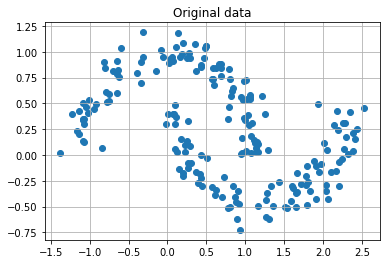

In [ ]:
# Get initial data points
df = pd.read_csv('twomoons.dat', header=None)
num_samples = df.shape[0]
x_dim = len(df.iloc[0][0].split()) - 1

y = np.array([int(float(df.iloc[i][0].split()[0])) for i in range(num_samples)])
x = np.array([[float(df.iloc[j][0].split()[i]) for i in range(1,x_dim+1)] for j in\
              range(num_samples)])

plt.scatter(x[:,0],x[:,1])
plt.title('Original data')
plt.grid()
plt.savefig('2-1-1.png', dpi=500)
plt.show()

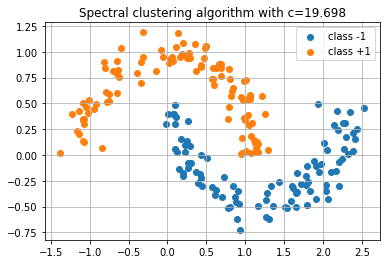

In [ ]:
# Get optimal c and plot the clustered data
c_list = [2**i for i in np.arange(-10,10.01,0.1)]
opt_c1, opt_y_hat1 = plot_best_figure(x, y, c_list, task=1)

## Task 2

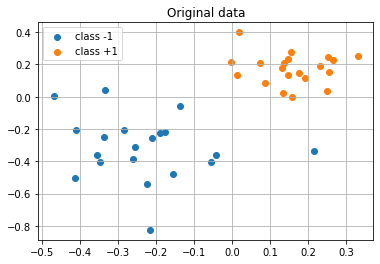

In [ ]:
# Generate self-designed dataset
c_list = [2**i for i in np.arange(-10,10.01,0.1)]
np.random.seed(27)
class1 = np.random.multivariate_normal([-0.3,-0.3], 0.04*np.identity(2), size=20)
label1 = -1 * np.ones(20)
class2 = np.random.multivariate_normal([0.15,0.15], 0.01*np.identity(2), size=20)
label2 = np.ones(20)
x = np.vstack((class1, class2))
y = np.hstack((label1, label2))

# Plot data with its label
fig, ax = plt.subplots()
ax.scatter(class1[:,0], class1[:,1], label='class -1')
ax.scatter(class2[:,0], class2[:,1], label='class +1')
plt.legend()
plt.grid()
plt.title('Original data')
plt.savefig('2-2-1.png', dpi=500)
plt.show()

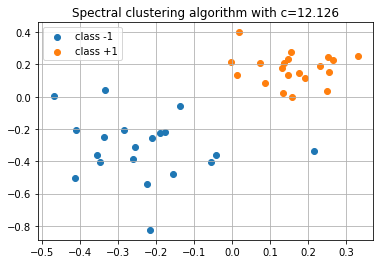

In [ ]:
# Get c and its clustered data
opt_c2, opt_y_hat2 = plot_best_figure(x, y, c_list, task=2)

## Task 3

In [ ]:
!wget http://www0.cs.ucl.ac.uk/staff/M.Herbster/SL/misc/dtrain123.dat

--2021-12-13 14:46:09--  http://www0.cs.ucl.ac.uk/staff/M.Herbster/SL/misc/dtrain123.dat
Resolving www0.cs.ucl.ac.uk (www0.cs.ucl.ac.uk)... 128.16.6.8
Connecting to www0.cs.ucl.ac.uk (www0.cs.ucl.ac.uk)|128.16.6.8|:80... connected.
HTTP request sent, awaiting response... 200 Document follows
Length: 555910 (543K) [text/plain]
Saving to: ‘dtrain123.dat’

dtrain123.dat       100%[===================>] 542.88K  38.0KB/s    in 14s     

2021-12-13 14:46:24 (38.9 KB/s) - ‘dtrain123.dat’ saved [555910/555910]



In [ ]:
# Initialize dataframe and some variables
df = pd.read_csv('dtrain123.dat', header=None)
num_samples = df.shape[0]
x_dim = len(df.iloc[0][0].split()) - 1
x, y = [], []

# Get data with labels '1' and '3'
for i in range(num_samples):
    data = df.iloc[i][0].split()
    if float(data[0]) == 1 or float(data[0]) == 3:
        y.append(int(float(data[0])))
        x.append([float(data[j+1]) for j in range(x_dim)])
x, y = np.array(x), np.array(y)
new_num_samples = len(y)

# Change labels from {1,3} to {-1,1} for the convenience of comparison
classy = np.zeros(new_num_samples)
for i in range(new_num_samples):
    classy[i] = 2 * (y[i]==1) - 1

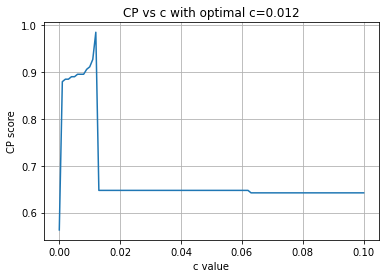

In [ ]:
# With different c, get CP score
cp_list = []
c_list = np.arange(0,0.1001,0.001)
for c in c_list:
    W = W_matrix(x, c)
    L = L_matrix(W)
    y_hat = cluster(L)
    l_pos, l_neg = 0, 0
    for i in range(new_num_samples):
        if y_hat[i] == classy[i]:
            l_pos += 1
        else:
            l_neg += 1
    cp_list.append(max(l_pos, l_neg) / new_num_samples)
cp_list = np.array(cp_list)
opt_c = c_list[np.argmax(cp_list)]

# Plot the figure
plt.plot(c_list, cp_list)
plt.xlabel("c value")
plt.ylabel("CP score")
plt.title('CP vs c with optimal c={}'.format(opt_c))
plt.grid()
plt.savefig("2-3.png",dpi=800)

## Plot for question 4

In [ ]:
# Get sorted eigenvalue list with different c values
eigenvalue_list = []
c_list = np.arange(0,0.1001,0.001)
for c in c_list:
    W = W_matrix(x, c)
    L = L_matrix(W)
    eigenvalue, eigenvector = eig(L)
    norm_eigenvalue = np.zeros(len(eigenvalue))
    for i in range(len(eigenvalue)):
        norm_eigenvalue[i] = norm(eigenvalue[i])
    norm_eigenvalue = sorted(norm_eigenvalue)
    eigenvalue_list.append(norm_eigenvalue)
eigenvalue_list = np.array(eigenvalue_list)

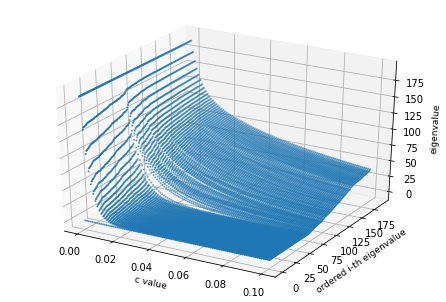

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Flatten x and y aixs
c_tile = np.tile(c_list, len(eigenvalue))
x_axis = np.reshape(c_tile, (len(eigenvalue), len(c_list))).transpose(1,0).flatten()
index_tile = np.tile(np.arange(1,len(eigenvalue)+1), len(c_list))
y_axis = np.reshape(index_tile, (len(c_list), len(eigenvalue))).flatten()

# Plot the figure
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax = Axes3D(fig)
ax.scatter(x_axis, y_axis, eigenvalue_list, s=1)
ax.set_xlabel('c value', fontsize=9, rotation=150)
ax.set_ylabel('ordered i-th eigenvalue', fontsize=9, rotation=150)
ax.set_zlabel('eigenvalue', fontsize=9)
plt.savefig('2-3-b.png', dpi=500)
plt.show()

# PART3

## functions for P3

In [ ]:
import numpy as np
import time
from numpy.linalg import pinv as pinv

def gen_data(m, n, winnow=False, knn=False):
    # This function aims to provide data for each algorithm
    '''
        Input:
            -m: int, number of data points
            -n: int, number of data dimension
            -winnow: bool, if winnow, we provide x in {0, 1}^n
            -knn: bool
        Output:
            X_train:  training data matrix with size m*n
            y_train:   training data label vector with size m*1
            X_test:    testing data matrix with size 10000*n
            y_test:    testing data label vector with size m*1
    '''
    if not winnow:
        X_train = np.random.randint(2, size=(m,n))*2-1 #size m*n
        X_test = np.random.randint(2, size=(10000,n))*2-1
    if winnow:
        X_train = np.random.randint(2, size=(m,n)) #size m*n
        X_test = np.random.randint(2, size=(10000,n))
    if knn:
        X_train = np.random.randint(2, size=(m,n))*2-1 #size m*n
        X_test = np.random.randint(2, size=(10000,n))*2-1
    y_train = X_train[:, 0]
    y_test = X_test[:, 0]
    
    return X_train, y_train, X_test, y_test



def sign(x):
    #sign function
    if x < 0:
        return -1
    elif x > 0:
        return 1
    else:
        return 0

def perceprtron(X_train, y_train, X_test, y_test):
    #This function aims to realize the function of perceptron
    '''
        Input:
            -X_train: training data matrix
            -y_train: training data label vector
            -X_test: testing data matrix
            -y_test: testing data label vector
        Output:
            -test_mistakes: int, mistakes on test data set
    '''

    data_mat_train = np.dot(X_train, np.transpose(X_train))#create data matrix
    data_mat_test = np.dot(X_test, np.transpose(X_train))
    #initialize alpha
    alpha = np.zeros(len(X_train))
    
    for i, x in enumerate(X_train):
        pred_val = np.dot(data_mat_train[i], alpha)
        if sign(pred_val) != y_train[i]:
            if sign(pred_val) == 0:
                alpha[i] = y_train[i]
            alpha[i] -= sign(pred_val)

    test_mistakes = 0
    for i, x in enumerate(X_test):
        pred_val = np.dot(data_mat_test[i], alpha)
        if sign(pred_val) != y_test[i]:
            test_mistakes += 1
    return test_mistakes/len(X_test)




def winnow(X_train, y_train, X_test, y_test):
    #This function aims to realize the function of winnow
    '''
        Input:
            -X_train: training data matrix
            -y_train: training data label vector
            -X_test: testing data matrix
            -y_test: testing data label vector
        Output:
            -test_mistakes: int, mistakes on test data set
    '''

    w_vector = np.ones(len(X_train[0]))
    # train_mistakes = 0
    for i, x in enumerate(X_train):
        pred_val = 0 if np.dot(w_vector, x) < len(x) else 1
        if y_train[i] != pred_val:
            # train_mistakes += 1
            for j in range(len(x)):
                w_vector[j] = w_vector[j] * 2**((y_train[i] - pred_val) * x[j] + 0.0)
        # print(train_mistakes)

    test_mistakes = 0
    for i, x in enumerate(X_test):
        pred_val = 0 if np.dot(w_vector, x) < len(x) else 1
        if pred_val != y_test[i]:
            test_mistakes += 1
    return test_mistakes/len(X_test)



def ls(X_train, y_train, X_test, y_test):
    #This function aims to realize the function of least square
    '''
        Input:
            -X_train: training data matrix
            -y_train: training data label vector
            -X_test: testing data matrix
            -y_test: testing data label vector
        Output:
            -test_mistakes: int, mistakes on test data set
    '''
    w = np.dot(np.matmul(pinv(np.matmul(X_train.T, X_train)), X_train.T), y_train)
    
    test_mistakes = 0
    for i, x in enumerate(X_test):
        pred_val = sign(np.dot(w, x))
        if pred_val != y_test[i]:
            test_mistakes += 1
    return test_mistakes/len(X_test)

    
def knn(X_train, y_train, X_test, y_test, k=1):
    #This function aims to realize the function of 1NN
    '''
        Input:
            -X_train: training data matrix
            -y_train: training data label vector
            -X_test: testing data matrix
            -y_test: testing data label vector
        Output:
            -test_mistakes: int, mistakes on test data set
    '''
        x_test_tile = np.reshape(np.tile(X_test,len(X_train)), (len(X_test),len(X_train),len(X_test[0])))#broadcast
        x_train_tile = np.reshape(np.tile(X_train,len(X_test)), (len(X_train),len(X_test),len(X_train[0])))#broadcast
        x_train_tile = x_train_tile.transpose(1,0,2)
        dist_mat = np.sum((x_test_tile - x_train_tile)**2, axis=2) 
        pred_idx = np.argmin(dist_mat, axis=1)
        pred_val = y_train[pred_idx[:]]
        return sum(abs(pred_val - y_test)/2)/len(y_test)


def test_alg(alg, dim_range, winnow=False):
    # This function aims to derive the sample complexity of each algorithm
    '''
        Input:
            -alg: algorithm function
            -dim_range: range, dimension range we want to test
            -winnow: optional bool, used for generating corresponding data
        Output:
            -m_list: list of sample complexity, each entry corresponds to dimension n.
    '''
    m_list = []
    for n in dim_range:
        m = 1
        while True:
            #generate data
            X_train, y_train, X_test, y_test = gen_data(m, n,  winnow=winnow)
            err = alg(X_train, y_train, X_test, y_test)
            if err <= 0.1:
                #if error < 10%, we repeat five times to ensure at 
                # least 4 times will converge to less than 10%
                times = 0
                for _ in range(5):
                    m_fix = m
                    X_train, y_train, X_test, y_test = gen_data(m_fix, n, winnow=winnow)
                    err_sub = alg(X_train, y_train, X_test, y_test)
                    if err_sub <= 0.1:
                        times += 1
                if times == 5:
                    m_list.append(m)
                    break
            m += 1
        print('finish run on n = ', n)
    return m_list
# runs = 1
# dim_range = np.arange(1,101)

        

In [ ]:
print("start obtaining sample complexity")
runs = 20
dim_range = np.arange(1,101)


all_m_list_precep = []
all_m_list_winnow = []
all_m_list_ls = []

for run in range(runs):
    m_list_precep = test_alg(perceprtron, dim_range)
    m_list_winnow = test_alg(winnow, dim_range, winnow=True)
    m_list_ls = test_alg(ls, dim_range)

    all_m_list_precep.append(m_list_precep)
    all_m_list_winnow.append(m_list_winnow)
    all_m_list_ls.append(m_list_ls)

finish run on n =  1
finish run on n =  2
finish run on n =  3
finish run on n =  4
finish run on n =  5
finish run on n =  6
finish run on n =  7
finish run on n =  8
finish run on n =  9
finish run on n =  10
finish run on n =  11
finish run on n =  12
finish run on n =  13
finish run on n =  14
finish run on n =  15
finish run on n =  16
finish run on n =  17
finish run on n =  18
finish run on n =  19
finish run on n =  20
finish run on n =  21
finish run on n =  22
finish run on n =  23
finish run on n =  24
finish run on n =  25
finish run on n =  26
finish run on n =  27
finish run on n =  28
finish run on n =  29
finish run on n =  30
finish run on n =  31
finish run on n =  32
finish run on n =  33
finish run on n =  34
finish run on n =  35
finish run on n =  36
finish run on n =  37
finish run on n =  38
finish run on n =  39
finish run on n =  40
finish run on n =  41
finish run on n =  42
finish run on n =  43
finish run on n =  44
finish run on n =  45
finish run on n =  

In [ ]:
runs = 20
dim_range = np.arange(1,15+1)

all_m_list_knn = []
for run in range(runs):
    print('Run ', run)
    m_list_knn = []
    m = 1
    for n in dim_range:
        flag_knn = 0
        while flag_knn== 0:
            #generate data
            X_train, y_train, X_test, y_test = gen_data(m, n, knn=True)
            #1nn
            if flag_knn < 1:
                err_knn = knn(X_train, y_train, X_test, y_test)
                if err_knn <= 0.1:
                    m_list_knn.append(m)
                    flag_knn += 1 
            m += 1
        print('finish run on n = ', n)
    
    all_m_list_knn.append(m_list_knn)


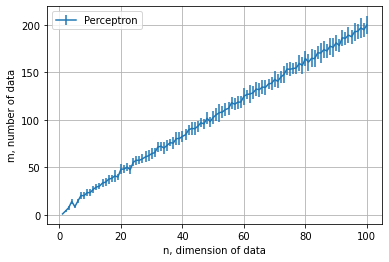

In [ ]:
print('sample complexity of perceptron' + "\n")
plt.errorbar(np.arange(1,101),np.mean(all_m_list_precep, axis=0),yerr = np.std(all_m_list_precep, axis=0), label='Perceptron')
plt.xlabel("n, dimension of data")
plt.ylabel("m, number of data")
plt.grid()
plt.legend()
plt.savefig('3-1-perceptron.png', dpi=500)
plt.show()

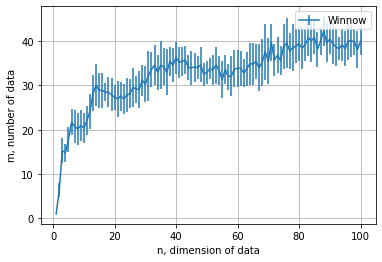

In [ ]:
print('sample complexity of winnow' + "\n")
plt.errorbar(np.arange(1,101),np.mean(all_m_list_winnow, axis=0),yerr = np.std(all_m_list_winnow, axis=0), label='Winnow')
plt.xlabel("n, dimension of data")
plt.ylabel("m, number of data")
plt.grid()
plt.legend()
plt.savefig('3-1-winnow.png', dpi=500)
plt.show()

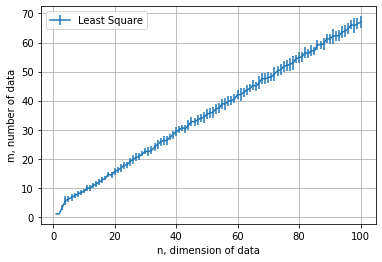

In [ ]:
print('sample complexity of ls' + "\n")
plt.errorbar(np.arange(1,101),np.mean(all_m_list_ls, axis=0),yerr = np.std(all_m_list_ls, axis=0), label='Least Square')
plt.xlabel("n, dimension of data")
plt.ylabel("m, number of data")
plt.grid()
plt.legend()
plt.savefig('3-1-ls.png', dpi=500)
plt.show()

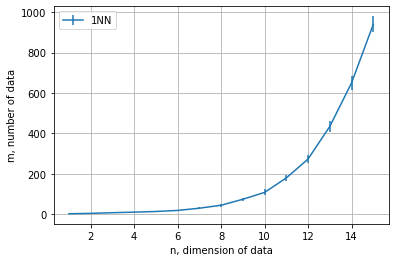

In [ ]:
print('sample complexity of 1NN' + "\n")
plt.errorbar(np.arange(1,16),np.mean(all_m_list_knn, axis=0),yerr = np.std(all_m_list_knn, axis=0), label='1NN')
plt.xlabel("n, dimension of data")
plt.ylabel("m, number of data")
plt.grid()
plt.legend()
plt.savefig('3-1-1nn.png', dpi=500)
plt.show()

In [2]:
import pandas as pd
import re
import numpy as np
import os
import requests
from sklearn import preprocessing
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.stats
from torch.autograd import Variable
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score


label_onehot = np.load('label_onthot.npy')

In [ ]:
score_array = np.load('score_array.npy')
num_class = score_array.shape[1]

fpr_dict = dict()
tpr_dict = dict()
roc_auc_dict = dict()
for i in tqdm(range(num_class)):
    fpr_dict[i], tpr_dict[i], _ = roc_curve(label_onehot[:, i], score_array[:, i])
    roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])